<a href="https://colab.research.google.com/github/ProvenDruid/metaparams/blob/main/metaparams_multioutputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

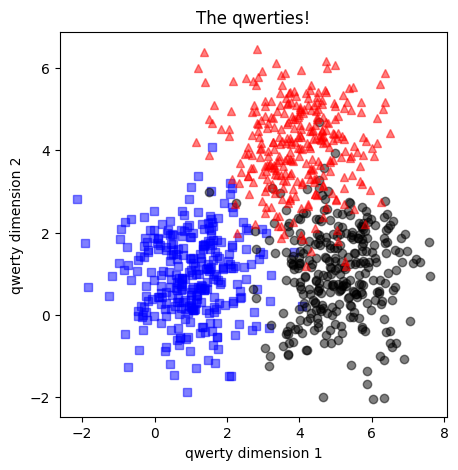

In [ ]:
# create data

nPerClust = 300
blur = 1

A = [  1,  1 ]
B = [  5,  1 ]
C = [  4,  4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

labels_np = np.hstack((np.zeros((nPerClust)),np.ones((nPerClust)),np.zeros((nPerClust))+2))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np, dtype=torch.long)

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0),0],data[np.where(labels==0),1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1),0],data[np.where(labels==1),1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2),0],data[np.where(labels==2),1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# **Now using dataLoaders**

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data,train_labels)
test_dataset  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [ ]:
# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


# **Now creating the model**

In [ ]:
# create a class for the model
def createTheQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# test the model with fake input

net,lossf,opt = createTheQwertyNet()
print(net)

# input is ten samples
input = torch.rand(10,2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[0.0650, 0.2043, 0.1530],
        [0.0912, 0.1936, 0.1110],
        [0.0922, 0.1885, 0.1011],
        [0.0594, 0.2033, 0.1560],
        [0.0519, 0.2019, 0.1601],
        [0.0818, 0.2075, 0.1438],
        [0.0912, 0.1937, 0.1111],
        [0.0600, 0.2034, 0.1557],
        [0.0883, 0.2088, 0.1403],
        [0.0792, 0.2070, 0.1453]], grad_fn=<AddmmBackward0>)

In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 100

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# run the model
trainAcc,testAcc,losses,net = function2trainTheModel()

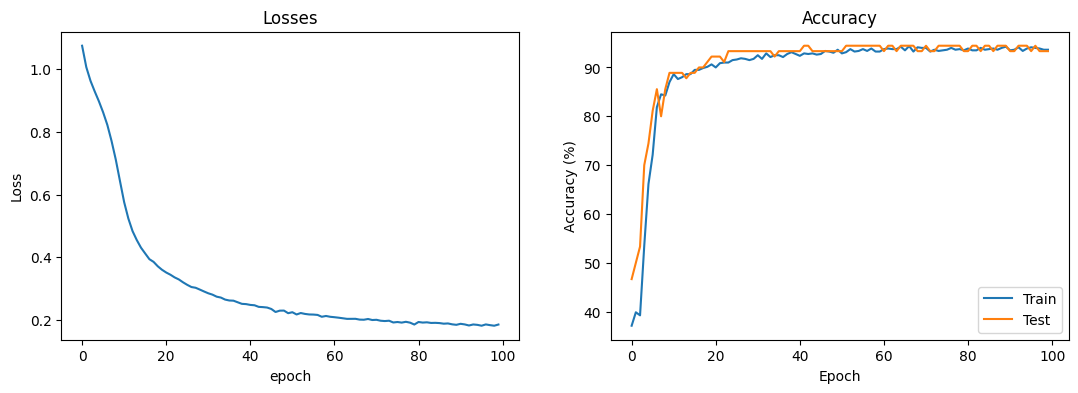

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
# run the data through the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat,axis=1)

# and plot those against the real data
plt.plot(predictions,'o',label='Predicted values')
plt.plot(labels+.2,'s',label='True values')
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

In [ ]:
# recode each prediction by accuracy
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100*accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
  accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])

plt.bar(range(3),accuracyByGroup)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final accuracy = {totalAcc:.2f}%')
plt.show()

In [ ]:
# Finally, show the qwerties in their native space, labeled by accuracy

# data markers
colorShapes = [ 'bs','ko','g^' ]


# show the data
fig = plt.figure(figsize=(7,7))

# plot correct and incorrect labeled data
for i in range(3):
  # plot all data points for this label
  plt.plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')

  # cross out the incorrect ones
  idxErr = (accuracy==0) & (labels==i)
  plt.plot(data[idxErr,0],data[idxErr,1],'rx')

plt.title(f'The qwerties! ({totalAcc:.0f}% accurately labeled)')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()